<h1> Initialize NEST and solve for LY, QY at all energies vs. Electric field</h1>

In [1]:
from __future__ import division
import sys
home_dir=!echo "$HOME"
sys.path.insert(2,home_dir[0]+'/iPyNb/NERSC_Import') 
sys.path.insert(2,home_dir[0]+'/LZ_git/fastNEST/libNEST') #add to import Lib-NEST
import libNEST
from pyROOT_import import *
from LZlim_pyNEST import *
from ROOT import TH2D, TFile, TBranch
import json
%pylab inline
pylab.rcParams['figure.figsize'] = (10.0, 8.0) # set size of figures"
plt.rcParams.update({'font.size': 18})

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


<h1> Calculate LY QY for ER </h1>

In [36]:
NEST=libNEST.NEST(1,10,100,2.888) # 0 is NR, 1 is ER ... Energy, EField(V/cm), density
myDet=libNEST.Detector()
myDet.LZSettings()
NEST.SetDetectorParameters(myDet)

LY=[]
QY=[]
Energy = logspace(-1,log10(5000),100)

for En in Energy:
    NEST.SetEnergy(En)
    LY_step=[]
    QY_step=[]
    for ii in arange(0,10000,1):
        NEST.DetectorResponse()
        LY_step.append(NEST.GetNumPhotons())
        QY_step.append(NEST.GetNumElectrons())
    LY.append(mean(np.array(LY_step))/En)
    QY.append(mean(np.array(QY_step))/En)

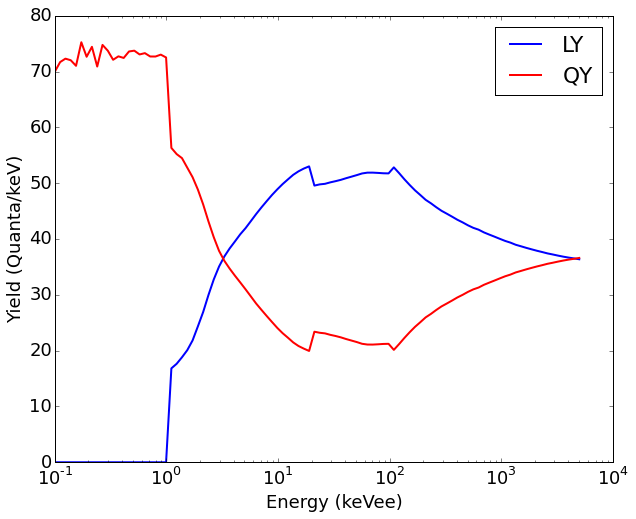

In [37]:
## semilogx(Energy,LY,linewidth=2)
semilogx(Energy,LY,'-b',linewidth=2)
semilogx(Energy,QY,'-r',linewidth=2)
xlabel('Energy (keVee)')
ylabel('Yield (Quanta/keV)')
legend(['LY','QY'])

<h1> Calculate LY QY for NR </h1>

In [26]:
NEST=libNEST.NEST(0,10,100,2.888) # 0 is NR, 1 is ER ... Energy, EField(V/cm), density
myDet=libNEST.Detector()
myDet.LZSettings()
NEST.SetDetectorParameters(myDet)

LY=[]
QY=[]
Energy = logspace(-1,log10(300),100)

for En in Energy:
    NEST.SetEnergy(En)
    LY_step=[]
    QY_step=[]
    for ii in arange(0,10000,1):
        NEST.DetectorResponse()
        LY_step.append(NEST.GetNumPhotons())
        QY_step.append(NEST.GetNumElectrons())
    LY.append(mean(np.array(LY_step))/En)
    QY.append(mean(np.array(QY_step))/En)

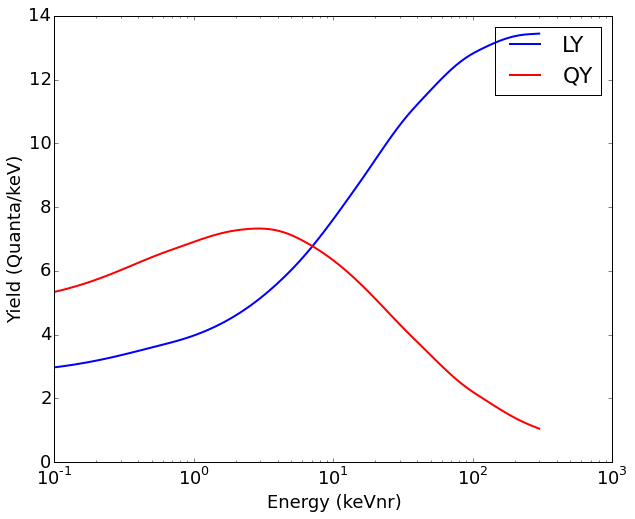

In [35]:
## semilogx(Energy,LY,linewidth=2)

#Smooth out the curve, save some compuational power
sLY = ip.UnivariateSpline(Energy, LY,s=0.1)
sQY = ip.UnivariateSpline(Energy, QY,s=0.1)

semilogx(Energy,sLY(Energy),'-b',linewidth=2)
semilogx(Energy,sQY(Energy),'-r',linewidth=2)
#semilogx(Energy,LY,'-b',linewidth=2)
#semilogx(Energy,QY,'-r',linewidth=2)
xlabel('Energy (keVnr)')
ylabel('Yield (Quanta/keV)')
legend(['LY','QY'])

<h1> Calculate ER yields at multiple fields </h1>

In [ ]:
NEST=libNEST.NEST(1,10,100,2.888) # 0 is NR, 1 is ER ... Energy, EField(V/cm), density
myDet=libNEST.Detector()
myDet.LZSettings()
NEST.SetDetectorParameters(myDet)

LY_list=[]
QY_list=[]
Energy = logspace(-1,log10(5000),100)
Efield=array([0,50,100,200,500,1000,2000])

for Ef in Efield:
    NEST.SetElectricField(Ef)
    LY=[]
    QY=[]
    for En in Energy:
        NEST.SetEnergy(En)
        LY_step=[]
        QY_step=[]
        for ii in arange(0,100000,1):
            NEST.DetectorResponse()
            LY_step.append(NEST.GetNumPhotons())
            QY_step.append(NEST.GetNumElectrons())
        LY.append(mean(np.array(LY_step))/En)
        QY.append(mean(np.array(QY_step))/En)
    LY_list.append(LY)
    QY_list.append(QY)

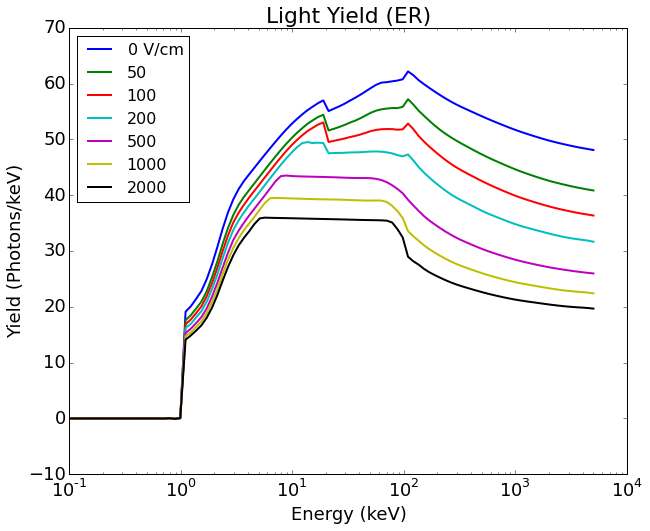

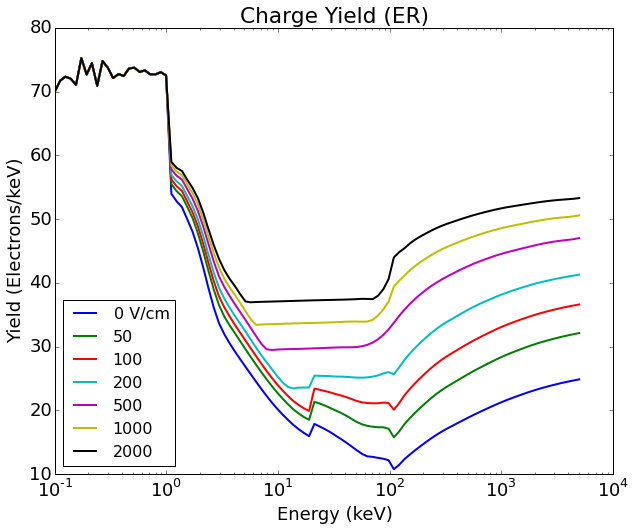

In [ ]:
legend_text=[]
for ii, Ef in enumerate(Efield):
    sLY = ip.UnivariateSpline(Energy, LY_list[ii],s=.05)
    semilogx(Energy,sLY(Energy),linewidth=2)
    #semilogx(Energy,LY_list[ii],linewidth=2)
    if ii==0:
        legend_text.append(str(Ef)+' V/cm')
    else:
        legend_text.append(str(Ef))
title('Light Yield (ER)')
xlabel('Energy (keV)')
ylabel('Yield (Photons/keV)')
legend(legend_text,fontsize=16,loc='upper left')

figure()
legend_text=[]
for ii, Ef in enumerate(Efield):
    sQY = ip.UnivariateSpline(Energy, QY_list[ii],s=.05)
    semilogx(Energy,sQY(Energy),linewidth=2)
    #semilogx(Energy,QY_list[ii],linewidth=2)
    if ii==0:
        legend_text.append(str(Ef)+' V/cm')
    else:
        legend_text.append(str(Ef))
title('Charge Yield (ER)')
xlabel('Energy (keV)')
ylabel('Yield (Electrons/keV)')
legend(legend_text,fontsize=16,loc='lower left')


<h1> Save data to mat and root </h1>

In [ ]:
Y_ER=dict([('Energy',Energy)])
for ii, Ef in enumerate(Efield):
    Y_ER.update([('LY-'+str(Ef)+'-Vcm',LY_list[ii])])
    Y_ER.update([('QY-'+str(Ef)+'-Vcm',QY_list[ii])])
#save mat
sio.savemat('NEST_Yields/ER_Yields_TDR',Y_ER)

#Write root file ... ROOT is just the worst, you have to fill element by element
f = TFile('NEST_Yields/ER_Yields_TDR.root', "recreate") 
t = TTree("tree", "ER Yields")
n=[]
vals=[]
for ii,(key,val) in enumerate(Y_ER.iteritems()):
    vals.append(val)
    n.append(np.array([0],dtype=float64))
    t.Branch(key, n[ii], key+'/d') #d is float64
#for kk, v in enumerate(val):

for jj in range(size(val)):
    for kk in range(ii):
        n[kk][0] =vals[kk][jj]
    t.Fill()

f.Write()
f.Close()

#load in data:
#matarr=sio.loadmat('NEST_Yields/ER_Yields_TDR.mat')
#rootarr=root2array('NEST_Yields/ER_Yields_TDR.root', treename='tree')

<h1> Calculate NR at multiple fields </h1>

In [ ]:
NEST=libNEST.NEST(0,10,100,2.888) # 0 is NR, 1 is ER ... Energy, EField(V/cm), density
myDet=libNEST.Detector()
myDet.LZSettings()
NEST.SetDetectorParameters(myDet)

LY_list_nr=[]
QY_list_nr=[]
Energy = logspace(-1,log10(300),100)
Efield=array([0,50,100,200,500,1000,2000])

for Ef in Efield:
    NEST.SetElectricField(Ef)
    LY=[]
    QY=[]
    for En in Energy:
        NEST.SetEnergy(En)
        LY_step=[]
        QY_step=[]
        for ii in arange(0,100000,1):
            NEST.DetectorResponse()
            LY_step.append(NEST.GetNumPhotons())
            QY_step.append(NEST.GetNumElectrons())
        LY.append(mean(np.array(LY_step))/En)
        QY.append(mean(np.array(QY_step))/En)
    LY_list_nr.append(LY)
    QY_list_nr.append(QY)

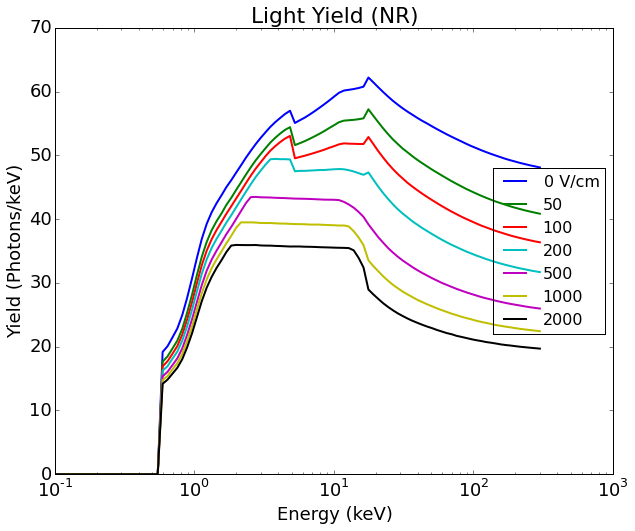

In [ ]:
legend_text=[]
for ii, Ef in enumerate(Efield):
    sLY = ip.UnivariateSpline(Energy, LY_list_nr[ii],s=.05)
    #semilogx(Energy,sLY(Energy),linewidth=2)
    semilogx(Energy,LY_list[ii],linewidth=2)
    if ii==0:
        legend_text.append(str(Ef)+' V/cm')
    else:
        legend_text.append(str(Ef))
title('Light Yield (NR)')
xlabel('Energy (keV)')
ylabel('Yield (Photons/keV)')
legend(legend_text,fontsize=16,loc='right')
#xlim([0.1,10])
#ylim([2,5])

figure()
legend_text=[]
for ii, Ef in enumerate(Efield):
    sQY = ip.UnivariateSpline(Energy, QY_list_nr[ii],s=.05)
    #semilogx(Energy,sQY(Energy),linewidth=2)
    semilogx(Energy,QY_list[ii],'-',linewidth=2)
    if ii==0:
        legend_text.append(str(Ef)+' V/cm')
    else:
        legend_text.append(str(Ef))
title('Charge Yield (NR)')
xlabel('Energy (keV)')
ylabel('Yield (Electrons/keV)')

#xlim([0.1,10])
legend(legend_text,fontsize=16,loc='right')

<h1> Save data to mat and root </h1>

In [103]:
Y_NR=dict([('Energy',Energy)])
for ii, Ef in enumerate(Efield):
    Y_NR.update([('LY-'+str(Ef)+'-Vcm',LY_list_nr[ii])])
    Y_NR.update([('QY-'+str(Ef)+'-Vcm',QY_list_nr[ii])])
#save mat
sio.savemat('NEST_Yields/NR_Yields_TDR',Y_NR)

#Write root file ... ROOT is just the worst, you have to fill element by element
f = TFile('NEST_Yields/NR_Yields_TDR.root', "recreate") 
t = TTree("tree", "NR Yields")
n=[]
vals=[]
for ii,(key,val) in enumerate(Y_NR.iteritems()):
    vals.append(val)
    n.append(np.array([0],dtype=float64))
    t.Branch(key, n[ii], key+'/d') #d is float64
#for kk, v in enumerate(val):

for jj in range(size(val)):
    for kk in range(ii):
        n[kk][0] =vals[kk][jj]
    t.Fill()

f.Write()
f.Close()

#load in data:
#matarr=sio.loadmat('NEST_Yields/ER_Yields_TDR.mat')
#rootarr=root2array('NEST_Yields/ER_Yields_TDR.root', treename='tree')